In [1]:
import numpy as np
import math
import random
import os
import scipy.spatial.distance

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T

from torch.optim.lr_scheduler import ReduceLROnPlateau

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm


import sys
sys.path.append(r"C:\Users\user\OneDrive - personalmicrosoftsoftware.uci.edu\2020Spring\CS175\175PointCloud")
from utils.TDS_utils import read_off, PointSampler, Normalize
from utils.camutils import makerotation, Camera
from utils.visutils import set_axes_equal_3d, label_axes

## Get dataset

In [2]:
from path import Path

path = Path("../Data/ModelNet10")
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

## sample 3d points

In [3]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
    verts, faces = read_off(f)

In [4]:
# sample points to get (x,y,z) points
pointcloud = PointSampler(1000)((verts, faces))

In [5]:
# Then, range of x,y,z should be between -1 and 1
norm_pointcloud = Normalize()(pointcloud)

In [6]:
norm_pointcloud.shape

(1000, 3)

In [7]:
path = "../Data/ModelNet10"
def get_3d_points(file_name):
    with open(path+'/'+file_name, 'r') as f:
        verts, faces = read_off(f)
        pointcloud = PointSampler(1000)((verts, faces))
        norm_pointcloud = Normalize()(pointcloud)
        return norm_pointcloud.T

## take 2d photo

In [8]:
cam = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))

In [9]:
# project 3d points to get 2d pointss
pts3 = norm_pointcloud.T
pts2 = cam.project(pts3)

In [10]:
def visual_2d(cams: ["cam"], pts3):
    n = len(cams)
    looks = []
    colors = cm.rainbow(np.linspace(0, 1, n))
    
    plt.rcParams['figure.figsize']=[3*n+3,3]
    # visualize pts2 
    fig = plt.figure()
    
    for i in range(n):
        pts2 = cams[i].project(pts3)
        ax = fig.add_subplot(1,n+1,i+1)
        ax.plot(pts2[0,:],pts2[1,:],'.', alpha = 0.3, ms = 5, c = colors[i])
        ax.add_patch(patches.Rectangle((0,0),32,32,color='r',fill=False))
#         plt.grid()
        plt.axis('square')
        plt.title('camera'+str(i))
        plt.axis("off")

        # visualize cam 
        looks.append(np.hstack((cams[i].t,cams[i].t+cams[i].R @ np.array([[0,0,0.5]]).T)))
    
    
    ax = fig.add_subplot(1,n+1,n+1,projection='3d')
    ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
    for i in range(n):
        ax.plot(cams[i].t[0],cams[i].t[1],cams[i].t[2],c = colors[i], marker = 'o', label = "cam"+str(i))
        ax.plot(looks[i][0,:],looks[i][1,:],looks[i][2,:],c = colors[i])

    set_axes_equal_3d(ax)
    label_axes(ax)
#     plt.legend()
    plt.title('scene 3D view')
    plt.show()

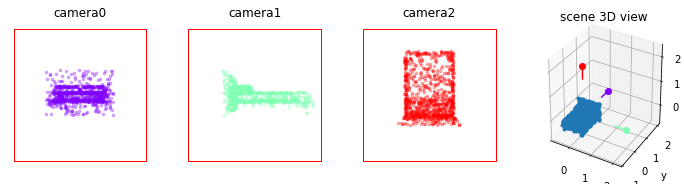

In [11]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0)@makerotation(0,0,270))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
visual_2d([cam1, cam2, cam3], pts3)

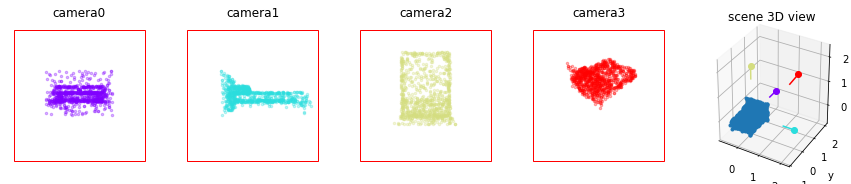

In [12]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0)@makerotation(0,0,270))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cam4 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,1.4,1.4]]).T, R=makerotation(135,0,-45))
visual_2d([cam1, cam2, cam3, cam4], pts3)

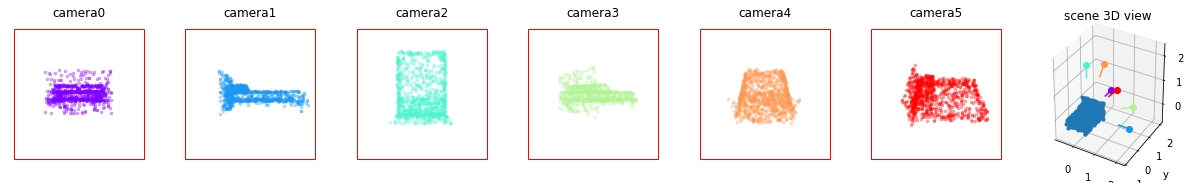

In [13]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0)@makerotation(0,0,270))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cam4 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,1.4,0]]).T, R=makerotation(90,0,-45))
cam5 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,1.4,1.4]]).T, R=makerotation(-225,0,0))
cam6 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,0,1.4]]).T, R=makerotation(0,-225,0)@makerotation(0,0,270))
visual_2d([cam1, cam2, cam3, cam4, cam5, cam6], pts3)

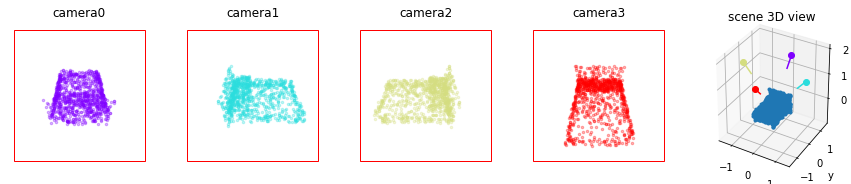

In [14]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,1.4,1.4]]).T, R=makerotation(135,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,0,1.4]]).T, R=makerotation(0,135,0)@makerotation(0,0,270))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[-1.4,0,1.4]]).T, R=makerotation(0,225,0)@makerotation(0,0,90))
cam4 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,-1.4, 1.4]]).T, R=makerotation(225,0,0)@makerotation(0,0,180))

visual_2d([cam1, cam2, cam3, cam4], pts3)

## Visualize more samples

bed/train/bed_0076.off


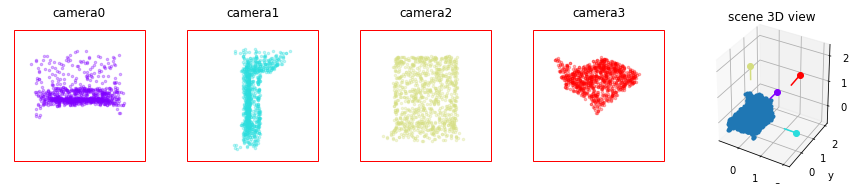

bed/train/bed_0272.off


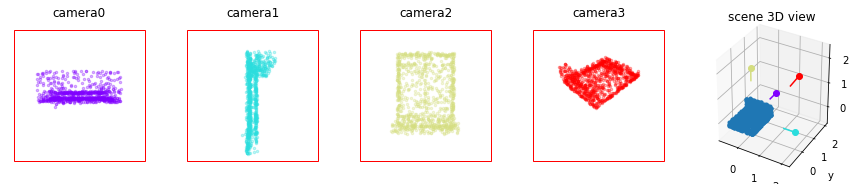

bed/train/bed_0047.off


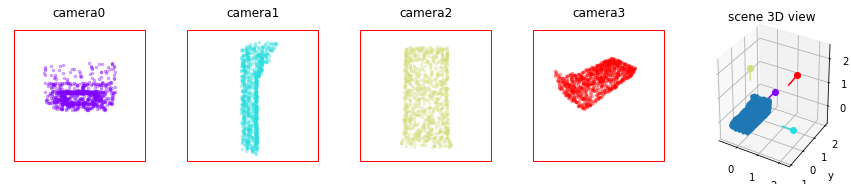

In [15]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cam4 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[1.4,1.4,1.4]]).T, R=makerotation(135,0,-45))
cams = [cam1,cam2,cam3,cam4]

for i in range(3):
    file_name = "bed/train/bed_" + str(np.random.randint(1,515)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points(file_name)
    visual_2d(cams, pts3)
    plt.show()

chair/train/chair_0668.off


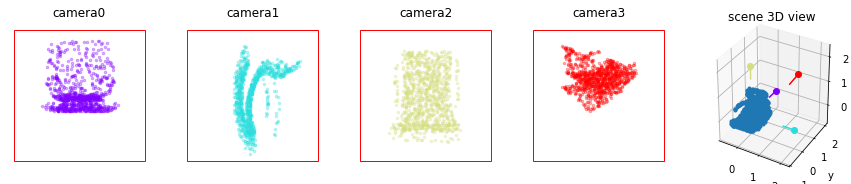

chair/train/chair_0414.off


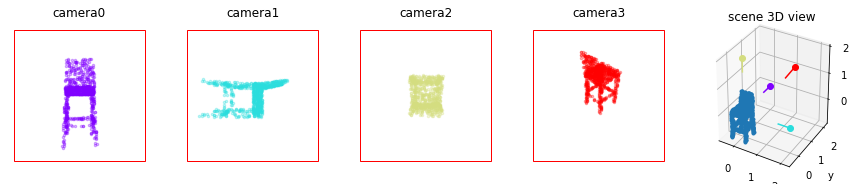

chair/train/chair_0218.off


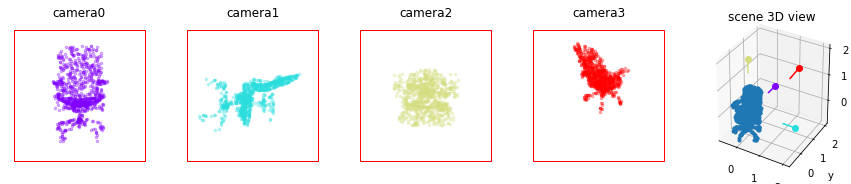

In [16]:
for i in range(3):
    file_name = "chair/train/chair_" + str(np.random.randint(1,889)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points(file_name)
    visual_2d(cams, pts3)
    plt.show()

night_stand/train/night_stand_0195.off


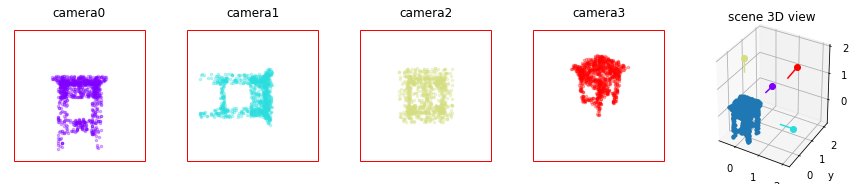

night_stand/train/night_stand_0019.off


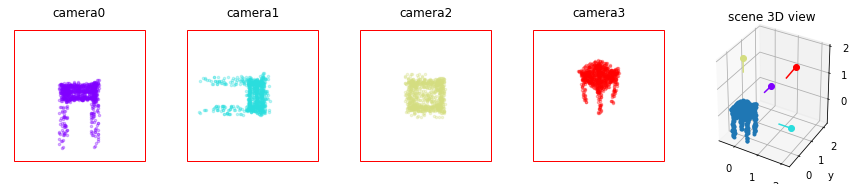

night_stand/train/night_stand_0151.off


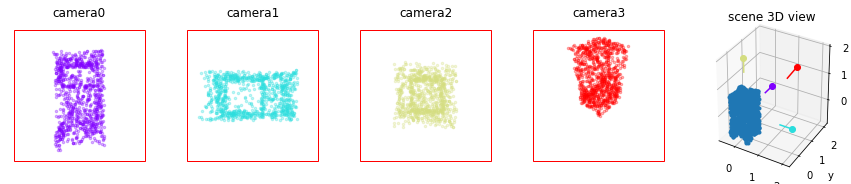

In [17]:
for i in range(3):
    file_name = "night_stand/train/night_stand_" + str(np.random.randint(1,200)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points(file_name)
    visual_2d(cams, pts3)
    plt.show()

dresser/train/dresser_0003.off


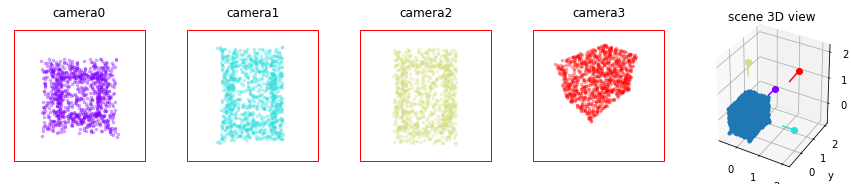

dresser/train/dresser_0075.off


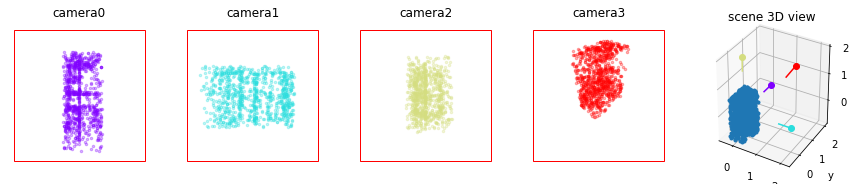

dresser/train/dresser_0080.off


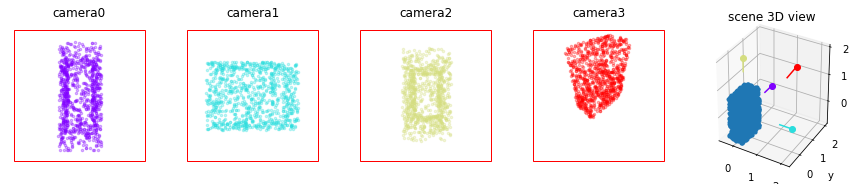

In [18]:
for i in range(3):
    file_name = "dresser/train/dresser_" + str(np.random.randint(1,200)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points(file_name)
    visual_2d(cams, pts3)
    plt.show()

## if need to augment data... adding noise

In [19]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [20]:
path = "../Data/ModelNet10"
def get_3d_points_with_noise(file_name):
    with open(path+'/'+file_name, 'r') as f:
        verts, faces = read_off(f)
        pointcloud = PointSampler(1000)((verts, faces))
        norm_pointcloud = Normalize()(pointcloud)
        rot_pointcloud = RandRotation_z()(norm_pointcloud)
        noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
        return noisy_rot_pointcloud

bed/train/bed_0116.off


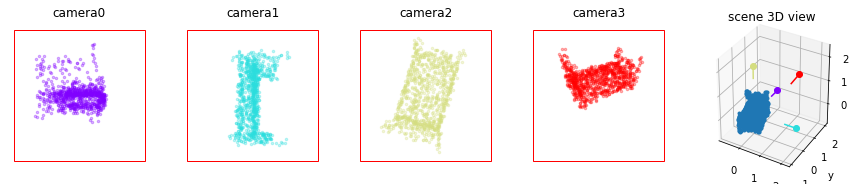

bed/train/bed_0498.off


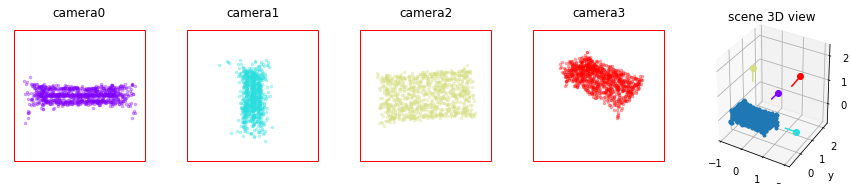

bed/train/bed_0386.off


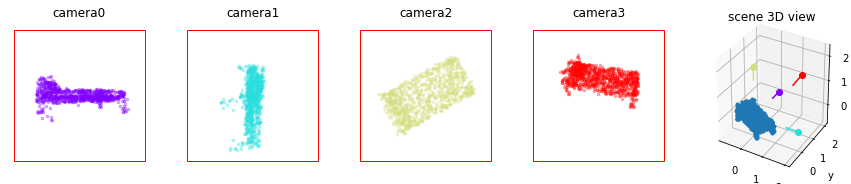

In [21]:
for i in range(3):
    file_name = "bed/train/bed_" + str(np.random.randint(1,515)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points_with_noise(file_name).T
    visual_2d(cams, pts3)
    plt.show()

chair/train/chair_0369.off


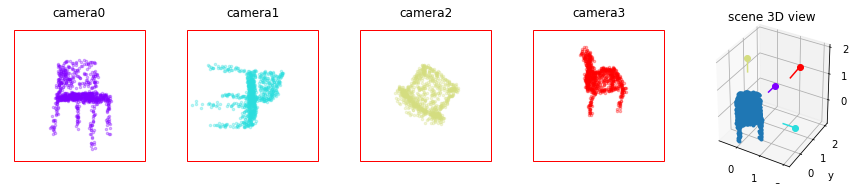

chair/train/chair_0004.off


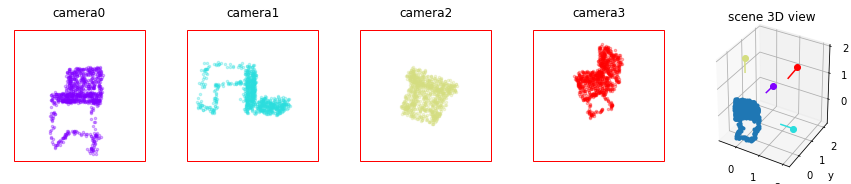

chair/train/chair_0127.off


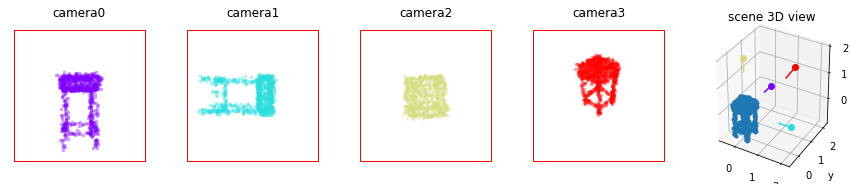

In [22]:
for i in range(3):
    file_name = "chair/train/chair_" + str(np.random.randint(1,889)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points_with_noise(file_name).T
    visual_2d(cams, pts3)
    plt.show()

## Creating data point

In [23]:
class create_data_point(object):
    def __init__(self, cams):
        self.cams = cams

    def __call__(self, pointcloud):
        n = len(self.cams)
        pts2 = np.zeros((n, 32, 32))
        for i in range(n):
            ind = self.cams[i].project(pointcloud.T).astype(int).T
            for k, j in ind:
                if 0 <= k < 32 and 0 <= j < 32:
                    pts2[i, j, k] += 1
        pts2 /= np.max(pts2)
        return pts2

night_stand/train/night_stand_0066.off


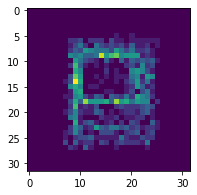

night_stand/train/night_stand_0079.off


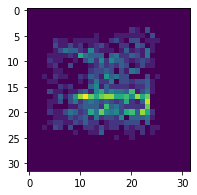

night_stand/train/night_stand_0170.off


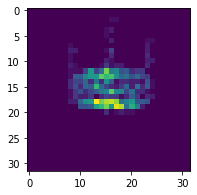

In [24]:
for i in range(3):
    file_name = "night_stand/train/night_stand_" + str(np.random.randint(1,200)).zfill(4) + ".off"
    print(file_name)
    pts3 = get_3d_points_with_noise(file_name)
    pts2 = create_data_point(cams)(pts3)
    plt.imshow(pts2[0,:,:])
    plt.show()

## Creating data set

In [25]:
class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)

In [26]:
cam1 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,2,0]]).T, R=makerotation(90,0,0))
cam2 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[2,0,0]]).T, R=makerotation(0,90,0)@makerotation(0,0,270))
cam3 = Camera(f=25,c=np.array([[16,16]]).T,t=np.array([[0,0,2]]).T, R=makerotation(180,0,0))
cams = [cam1, cam2, cam3]


train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    create_data_point(cams),
                    ToTensor()
                    ])
def default_transforms():
    return transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    create_data_point(cams),
                    ToTensor()
                    ])

In [27]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [28]:
train_ds = PointCloudData(Path(path), transform=train_transforms)
valid_ds = PointCloudData(Path(path), valid=True, folder='test', transform=default_transforms)

In [29]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [30]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([3, 32, 32])
Class:  bathtub


## Model

In [31]:
class ConvOneView(nn.Module):
    def __init__(self):
        '''extracting features from single view'''
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.pool = nn.MaxPool2d(2)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(2304, 1024)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        # input.shape == (bs,1,32,32)

        # bs = input.size(0)
        xb = self.pool(self.relu(self.bn1(self.conv1(input))))
        xb = self.pool(self.relu(self.bn2(self.conv2(xb))))

        flat = nn.Flatten()(xb)
        xb = self.relu(self.bn3(self.fc1(flat)))

        return xb


class CombineMultiView(nn.Module):
    '''extracting features from multi views'''

    def __init__(self):
        super().__init__()
        self.conv1 = ConvOneView()

    def forward(self, input):
        # print(list(input[:,0,:,:][:,None,:,:].size()))
        n = list(input.size())[1]
        layers = []
        for i in range(n):
            layer = self.conv1(input[:, i, :, :][:, None, :, :])
            layers.append(layer)

        xb = nn.MaxPool1d(n)(torch.stack(layers, 2))
        # print(list(xb.size()))

        output = nn.Flatten(1)(xb)



        return output


class MVNet(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        self.CombineMultiView = CombineMultiView()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb = self.CombineMultiView(input)
        xb = nn.ReLU(inplace=True)(self.bn1(self.fc1(xb)))
        xb = nn.ReLU(inplace=True)(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output)

In [32]:
def check_accuracy(model, loader, train = False):
    num_correct = 0
    num_samples = 0
    model.eval()  # Put the model in test mode (the opposite of model.train(), essentially)
    for i, data in enumerate(loader):
        x_var, y = data['pointcloud'].to(device).float(), data['category']

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if train:
        print("Training : ", end='')
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


def train(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=1, save=False):

    scheduler = ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=2)

    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, data in enumerate(train_loader):
            x_var, y_var = data['pointcloud'].to(device).float(), data['category'].to(device)

            scores = model(x_var)

            loss = loss_fn(scores, y_var)
            if (t + 1) % 10 == 0:
                print('loss = %.4f' % (loss.data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        check_accuracy(model, train_loader, train = True)
        val_acc = check_accuracy(model, val_loader)
        scheduler.step(val_acc)

        if save:
            torch.save(model.state_dict(), "save_v4_" + str(epoch) + ".pth")

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
pointnet = MVNet()
pointnet.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pointnet.parameters(), lr=0.1, momentum=0.9)

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [35]:
# train(pointnet, loss_fn, optimizer, train_loader, valid_loader, num_epochs=3, save=False)

In [36]:
# check_accuracy(pointnet, valid_loader)

## Results

In [37]:
def read_acc(filename):
    result = []
    for line in open(filename):
        if line.startswith("Got"):
            result.append(eval(line[-7:-2])/100)
    return result

In [38]:
cam3result = read_acc("3cams.txt")
cam4result = read_acc("4cams_result.txt")
cam4upresult = read_acc("4upcams_result.txt")
cam6result = read_acc("6cams_result.txt")

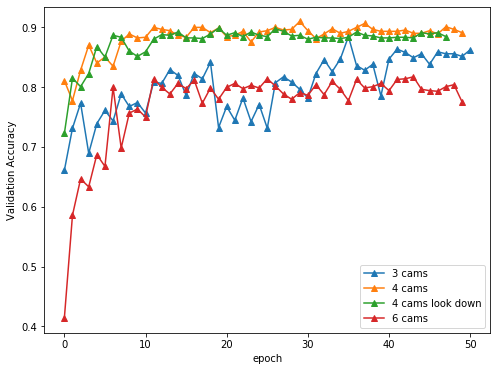

In [39]:
plt.figure(figsize=(8,6))

plt.plot(cam3result, marker = '^', label = "3 cams")
plt.plot(cam4result, marker = '^', label = "4 cams")
plt.plot(cam4upresult, marker = '^', label = "4 cams look down")
plt.plot(cam6result, marker = '^', label = "6 cams")

plt.ylabel("Validation Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [40]:
def read_loss(filename):
    result = []
    temp = []
    for line in open(filename):
        if line.startswith("loss"):
            temp.append(eval(line.strip().split()[-1]))
        elif line.startswith("Got"):
            result.append(np.mean(temp))
            temp = []
    return result

In [41]:
cam3loss = read_loss("3cams.txt")
cam4loss = read_loss("4cams_result.txt")
cam4uploss = read_loss("4upcams_result.txt")
cam6loss = read_loss("6cams_result.txt")

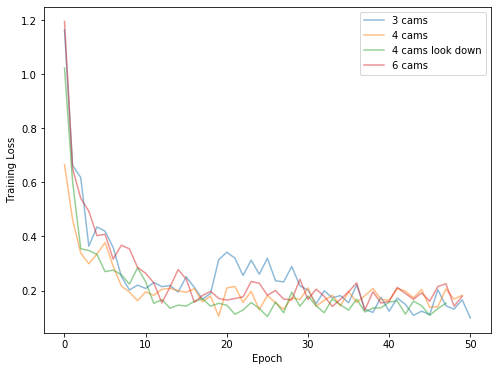

In [42]:
plt.figure(figsize=(8,6))

plt.plot(cam3loss, label = "3 cams", alpha = 0.5)
plt.plot(cam4loss, label = "4 cams", alpha = 0.5)
plt.plot(cam4uploss, label = "4 cams look down", alpha = 0.5)
plt.plot(cam6loss, label = "6 cams", alpha = 0.5)

plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## summerize best model

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
pointnet = MVNet()
pointnet.load_state_dict(torch.load('save_v4_29_acc91.pth'))
pointnet.eval()

MVNet(
  (CombineMultiView): CombineMultiView(
    (conv1): ConvOneView(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU(inplace=True)
      (fc1): Linear(in_features=2304, out_features=1024, bias=True)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, mome

In [45]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs = pointnet(inputs)
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        
#         print(list(preds.numpy()))
#         print(list(labels.numpy()))

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [46]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 47,   3,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  88,   0,   0,   0,   0,   0,   0,   9,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,  58,   1,   0,   3,   1,  19,   0],
       [  0,   0,   1,   0,  57,   0,  27,   0,   1,   0],
       [  0,   0,   4,   0,   1,  89,   5,   1,   0,   0],
       [  0,   0,   0,   0,   4,   0,  79,   0,   3,   0],
       [  4,   1,   2,   0,   1,   0,   1,  91,   0,   0],
       [  0,   0,   1,   3,   0,   0,   0,   0,  96,   0],
       [  0,   1,  13,   0,   0,   0,   1,   0,   1,  84]], dtype=int64)

In [47]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1,1, figsize = (12,12))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


<Figure size 576x576 with 0 Axes>

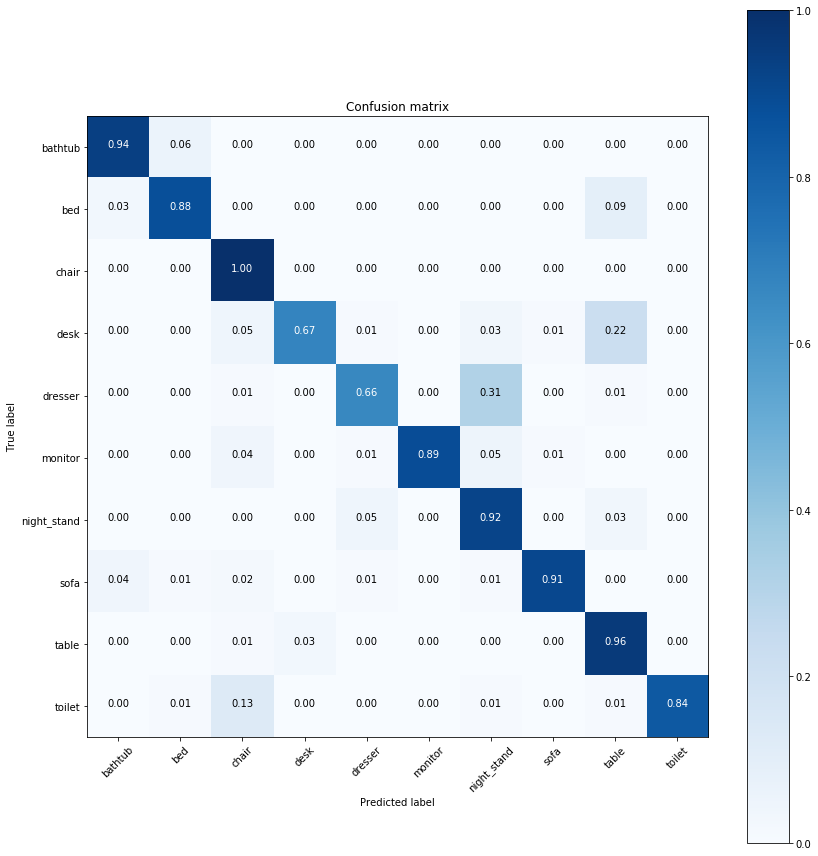

In [48]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


<Figure size 576x576 with 0 Axes>

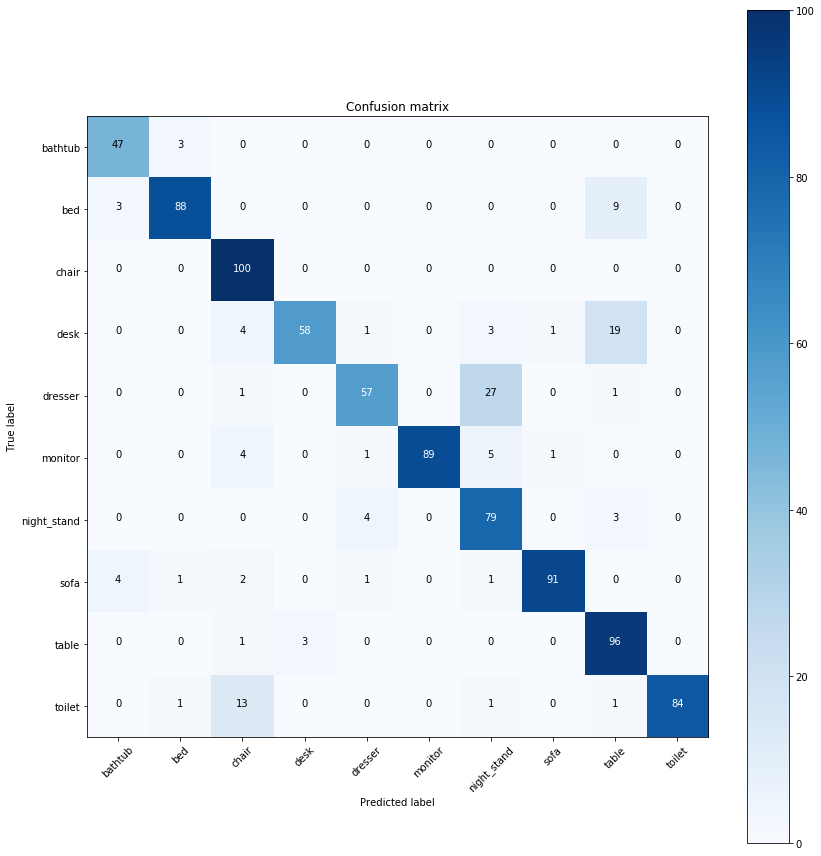

In [49]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)